<a href="https://colab.research.google.com/github/DavianYang/kidney-ct-classification/blob/main/kidney_stone_ct_detection_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nazmul0087_ct_kidney_dataset_normal_cyst_tumor_and_stone_path = kagglehub.dataset_download('nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone')

print('Data source import complete.')

Data source import complete.


In [65]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import os
import math
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Exploration

Cyst: 3709 images
Tumor: 2283 images
Stone: 1377 images
Normal: 5077 images


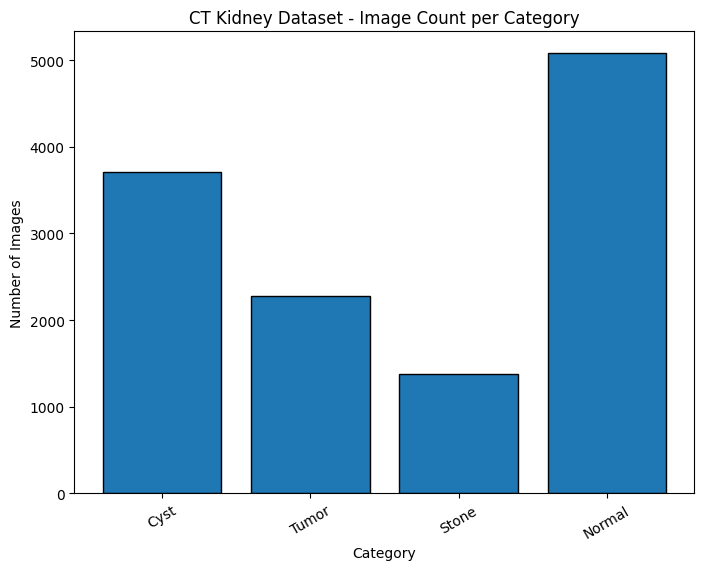

In [68]:
root_dir = Path('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

categories = []
counts = []

for category_path in root_dir.iterdir():
    if category_path.is_dir():
        num_images = len(list(category_path.iterdir()))
        print(f"{category_path.name}: {num_images} images")
        categories.append(category_path.name)
        counts.append(num_images)

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, edgecolor="black")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("CT Kidney Dataset - Image Count per Category")
plt.xticks(rotation=30)
plt.show()

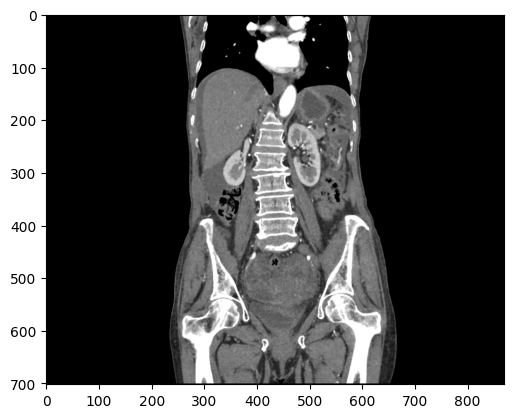

(869, 702) RGB


In [69]:
normal_dir = root_dir / "Normal"

sample_path = next(normal_dir.iterdir())
img = Image.open(sample_path)
plt.imshow(img, cmap='gray')
plt.show()
print(img.size, img.mode)

In [70]:
import numpy as np

img_arr = np.array(img)
print("Min: ", img_arr.min(), "Max: ", img_arr.max(), "Mean: ", img_arr.mean())

Min:  0 Max:  255 Mean:  48.15046111881555


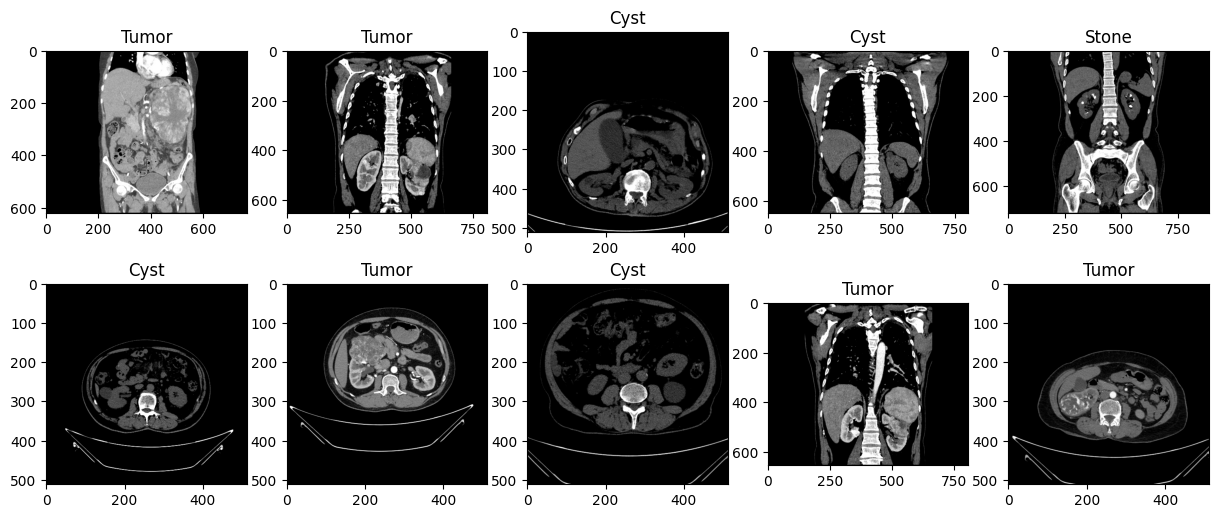

In [71]:
import random

categories = [c for c in root_dir.iterdir() if c.is_dir()]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    category = random.choice(categories)
    img_path = random.choice(list(category.iterdir()))
    img = Image.open(img_path)
    ax.set_title(category.name)
    ax.imshow(img, cmap='gray')
plt.show()

In [72]:
df = pd.read_csv('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv')
df.head(5)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [73]:
img_path_list = list(root_dir.glob('*/*'))
len(img_path_list), len(df)

(12446, 12446)

In [74]:
img_num = min(20, len(img_path_list))
ran_img_list = random.sample(img_path_list,img_num)

img_name = [img.stem for img in ran_img_list]
label = df[df['image_id'].isin(img_name)]['Class'].to_list()
label

['Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Tumor',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Stone',
 'Cyst',
 'Cyst',
 'Cyst',
 'Cyst',
 'Cyst',
 'Cyst',
 'Cyst',
 'Cyst']

In [75]:
sample_five = [name.stem for name in img_path_list[:5]]
sample_five

['Cyst- (3178)', 'Cyst- (3561)', 'Cyst- (900)', 'Cyst- (1148)', 'Cyst- (268)']

In [76]:
df[df['image_id'].isin(sample_five)]

,Unnamed: 0,image_id,path,diag,target,Class
10297,10297,Cyst- (1148),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
10921,10921,Cyst- (268),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
11705,11705,Cyst- (3561),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
11856,11856,Cyst- (3178),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12089,12089,Cyst- (900),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


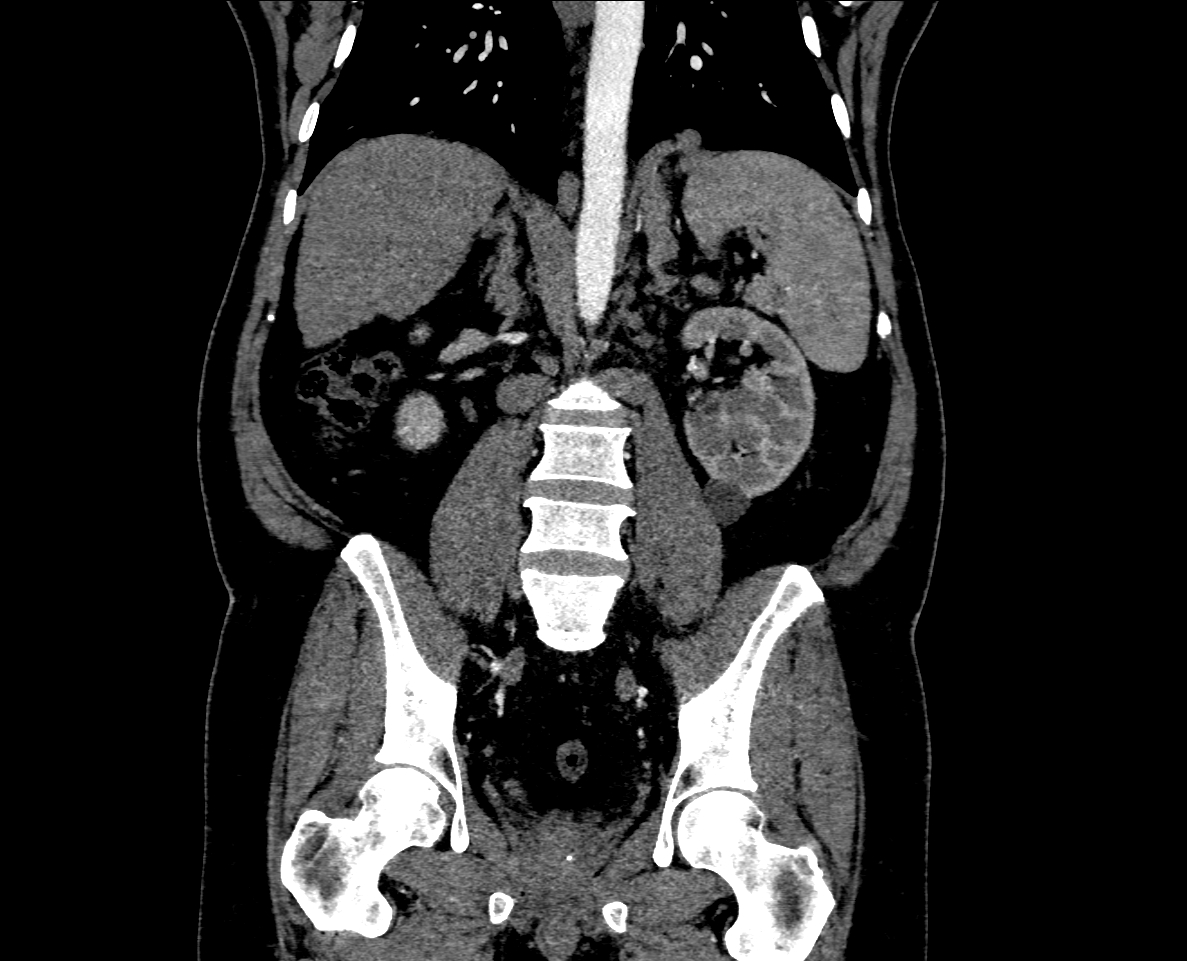

In [77]:
row = df.iloc[0]
sample_path = root_dir / row['diag'] / (row['image_id'] + '.jpg')
sample_image = Image.open(sample_path).convert('RGB')
sample_target = row['Class']
sample_image

In [78]:
df['target'].unique()

array([3, 1, 2, 0])

In [79]:
df['Class'].unique()

array(['Tumor', 'Normal', 'Stone', 'Cyst'], dtype=object)

## Preprocessing

In [80]:
from torch.utils.data import Dataset

class KidneyDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        self.csv = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        img_path = self.root_dir / row['diag'] / (row['image_id'] + '.jpg')
        img = Image.open(img_path).convert('RGB')
        label = row['target']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [82]:
csv_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv'

### Computing Mean And Variance

In [103]:
from torch.utils.data import DataLoader
import torch

train_dataset = KidneyDataset(
    csv_dir=csv_dir,
    root_dir=root_dir,
    transform=v2.Compose([v2.Resize((224, 224)), v2.ToTensor()])
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Calculating dataset-specifi Mean/STD

In [95]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2

stats_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

stats_dataset = KidneyDataset(csv_dir, root_dir, transform=stats_transform)
stats_loader = DataLoader(stats_dataset, batch_size=64, shuffle=False, num_workers=4)

def get_dataset_mean_std(loader, decimals=4):
    channels_sum = 0.0
    channels_squared_sum = 0.0
    num_batches = 0

    for data, _ in loader:
        channels_sum += data.mean(dim=[0, 2, 3])
        channels_squared_sum += (data ** 2).mean(dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2).sqrt()

    mean = torch.round(mean * 10**decimals) / 10**decimals
    std = torch.round(std * 10**decimals) / 10**decimals

    return mean, std

mean, std = get_dataset_mean_std(stats_loader, decimals=4)

print(f"Dataset mean: {mean.tolist()}")
print(f"Dataset std:  {std.tolist()}")


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Dataset mean: [0.1437000036239624, 0.1437000036239624, 0.1437000036239624]
Dataset std:  [0.23360000550746918, 0.23360000550746918, 0.23360000550746918]


### Processing balanced dataset split

In [104]:
temp_dataset = KidneyDataset(csv_dir, root_dir, transform=None)

all_labels = temp_dataset.csv['Class']
all_labels

,Class
0,Tumor
1,Tumor
2,Tumor
3,Tumor
4,Tumor
...,...
12441,Cyst
12442,Cyst
12443,Cyst
12444,Cyst


In [97]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

batch_size = 32

train_transform = v2.Compose([
v2.Resize((224, 224)),

    # 1. Geometric Augmentations (Anatomical variance)
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5), # Safe for CT slices
    v2.RandomRotation(degrees=20),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),

    # 2. Intensity/Contrast (Scanner variance)
    # Don't change hue or saturation (CTs are essentially grayscale)
    v2.ColorJitter(brightness=0.2, contrast=0.2),

    # 3. Medical Specific (Sharpness helps find Stones)
    v2.RandomAdjustSharpness(sharpness_factor=2, p=0.5),

    # 4. Noise (Scanner grain)
    v2.RandomApply([v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.3),

    v2.ToImage(), # Standard for v2
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2337, 0.2337, 0.2337]),
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2337, 0.2337, 0.2337]),
])

temp_dataset = KidneyDataset(csv_dir, root_dir, transform=None)
dataset_size = len(temp_dataset)
indices = list(range(dataset_size))
all_labels = temp_dataset.csv['Class']

train_indices, temp_indices = train_test_split(
    indices,
    test_size=0.30,
    stratify=all_labels,
    random_state=42,
    shuffle=True
)

temp_labels = [all_labels[i] for i in temp_indices]

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42,
    shuffle=True
)

train_base = KidneyDataset(csv_dir, root_dir, transform=train_transform)
val_base = KidneyDataset(csv_dir, root_dir, transform=val_transform)
test_base = KidneyDataset(csv_dir, root_dir, transform=val_transform)

train_dataset = Subset(train_base, train_indices)
val_dataset = Subset(val_base, val_indices)
test_dataset = Subset(test_base, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_dataset)}")
print(f"Val set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

Training set: 8712
Val set: 1867
Test set: 1867


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [98]:
import pandas as pd

def check_distribution(dataset_subset, all_labels, set_name):
    subset_indices = dataset_subset.indices
    subset_labels = all_labels.iloc[subset_indices]

    counts = subset_labels.value_counts()
    percentages = subset_labels.value_counts(normalize=True) * 100

    print(f"\n--- {set_name} Distribution ---")
    for cls in counts.index:
        print(f"{cls}: {counts[cls]} samples ({percentages[cls]:.2f}%)")

check_distribution(train_dataset, df['Class'], "TRAIN")
check_distribution(val_dataset, df['Class'], "VALIDATION")
check_distribution(test_dataset, df['Class'], "TEST")


--- TRAIN Distribution ---
Normal: 3554 samples (40.79%)
Cyst: 2596 samples (29.80%)
Tumor: 1598 samples (18.34%)
Stone: 964 samples (11.07%)

--- VALIDATION Distribution ---
Normal: 762 samples (40.81%)
Cyst: 556 samples (29.78%)
Tumor: 343 samples (18.37%)
Stone: 206 samples (11.03%)

--- TEST Distribution ---
Normal: 761 samples (40.76%)
Cyst: 557 samples (29.83%)
Tumor: 342 samples (18.32%)
Stone: 207 samples (11.09%)


### Preview of Transformed Dataset

In [100]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

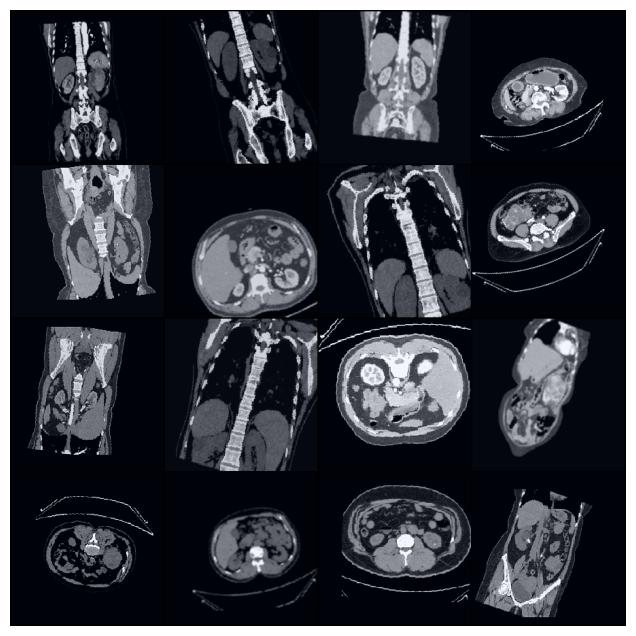

Labels: [3 0 1 1 2 1 0 3 1 0 1 3 0 2 2 2]


In [101]:
grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)

plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

print("Labels:", labels[:16].numpy())

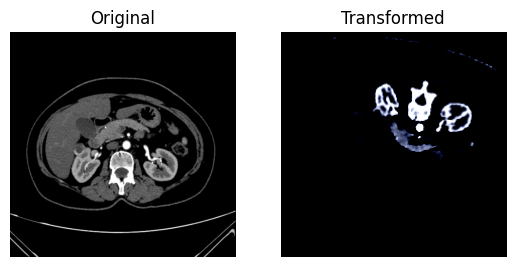

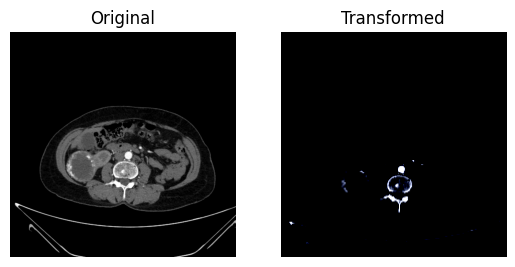

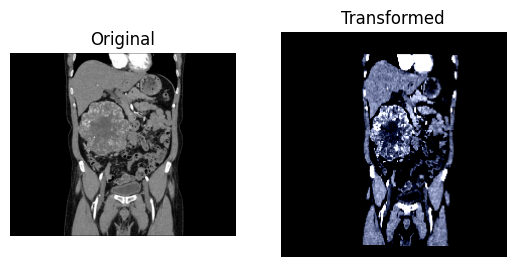

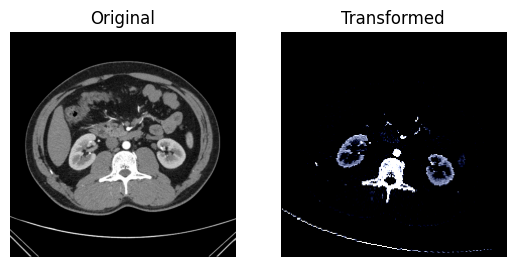

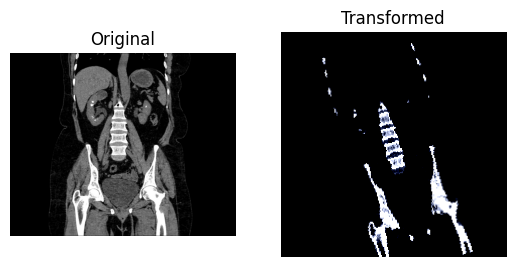

In [102]:
rand_img_list = random.sample(img_path_list, 5)

for i in rand_img_list:
    fig, axes = plt.subplots(1, 2, )
    img = Image.open(i).convert("RGB")

    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title("Original")


    transform_img = train_transform(img)
    transform_img = transform_img.permute(1, 2, 0).numpy()

    axes[1].imshow(transform_img)
    axes[1].axis("off")
    axes[1].set_title("Transformed")

## Test Training

In [91]:
# Define color codes for terminal
class Colors:
    RESET = '\033[0m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'

def display_progress_bar(batch_idx, num_batches, loss, accuracy):
    """
    Function to display a colored progress bar.
    Args:
        batch_idx: Current batch index
        num_batches: Total number of batches
        loss: Current loss value
        accuracy: Current accuracy value
    """
    progress = (batch_idx + 1) / num_batches
    bar_length = 40  # Length of the progress bar (number of '==' chars)
    filled_length = int(bar_length * progress)
    bar = f"{Colors.GREEN}{'=' * filled_length}{Colors.RED}{'-' * (bar_length - filled_length)}{Colors.RESET}"

    print(f'\r[{bar}] {batch_idx + 1}/{num_batches} | {Colors.YELLOW}Loss:{Colors.RESET} {loss:.3f} | {Colors.YELLOW}Accuracy:{Colors.RESET} {accuracy:.2f}%', end='', flush=True)

In [92]:
import matplotlib.pyplot as plt

def plot_result(history, title="Training Progress"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', color='tomato')
    plt.plot(epochs, history['val_loss'], label='Validation', color='steelblue')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', color='mediumseagreen')
    plt.plot(epochs, history['val_acc'], label='Validation', color='black')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [47]:
def train_one_epoch(model, trainloader, input_dim, show_progress):
  train_loss, avg_loss = 0.0, 0.0
  correct, total = 0, 0 # for accuracy calculation
  num_train_batches = len(trainloader)

  model.train()

  for batch_idx, (inputs, targets) in enumerate(trainloader):
      # flattening input dim for KAN
      # [batch_size, 3, H, W] -> [batch_size, input_dim * input_dim *]
      if input_dim is not None:
          inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, preds = outputs.max(1)
      total += targets.size(0)
      correct += preds.eq(targets).sum().item()

      if show_progress:
          acc = 100. * correct / total
          avg_loss = train_loss / (batch_idx + 1)
          display_progress_bar(batch_idx, num_train_batches, avg_loss, acc)

  train_epoch_loss = train_loss / num_train_batches
  train_epoch_acc = 100. * correct / total

  return train_epoch_loss, train_epoch_acc

In [48]:
def val_one_epoch(model, valloader, input_dim, show_progress):
  val_loss, avg_loss = 0.0, 0.0
  correct, total = 0, 0
  all_preds, all_targets = [], []
  num_val_batches = len(valloader)

  model.eval()

  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(valloader):

          if input_dim is not None:
              inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, targets)

          val_loss += loss.item()
          _, preds = outputs.max(1)
          total += targets.size(0)
          correct += preds.eq(targets).sum().item()

          all_preds.extend(preds.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())

          if show_progress:
            acc = 100. * correct / total
            avg_loss = val_loss / (batch_idx + 1)
            display_progress_bar(batch_idx, num_val_batches, avg_loss, acc)

  val_epoch_loss = val_loss / num_val_batches
  val_epoch_acc = 100. * correct / total

  return all_preds, all_targets, val_epoch_loss, val_epoch_acc

In [49]:
def train_model(model, trainloader, valloader, device,
                             optimizer, criterion, epochs=10, model_name="model", input_dim=None,
                             use_wandb=False, project_name=None, show_progress=True):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    best_vloss = 1_000_000.
    epochs_without_improvement = 0
    patience = 20
    best_model_state =  None

    model.to(device)
    start_time = time.time()

    if use_wandb:
        wandb.init(project=project_name)
        wandb.watch(model, log="all")

    for epoch in range(epochs):
        timestamp = datetime.fromtimestamp(start_time).strftime('%Y%m%d_%H%M%S')
        model_path = f"{model_name}_{timestamp}_{epoch}.pt"

        # ---------- Training ----------
        print(f"\nEpoch {epoch + 1}/{epochs} - Training")
        train_epoch_loss, train_epoch_acc= train_one_epoch(model, trainloader, input_dim, show_progress)
        train_loss_list.append(train_epoch_loss)
        train_acc_list.append(train_epoch_acc)

        # ---------- Evaluation ----------
        print(f"\nEpoch {epoch + 1}/{epochs} - Evaluation")
        all_preds, all_targets, val_epoch_loss, val_epoch_acc = val_one_epoch(model, valloader, input_dim, show_progress)
        val_loss_list.append(val_epoch_loss)
        val_acc_list.append(val_epoch_acc)

        # Track best performance, and save the model's state
        if val_epoch_loss < best_vloss:
          best_vloss = val_epoch_loss
          best_model_state = model.state_dict()
          torch.save(best_model_state, model_path)
          epochs_without_improvement = 0
        else:
          epochs_without_improvement += 1

        # If no imporvement for "patience" number of epochs, stop early
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping at epoch {epoch+1} with best validation loss: {best_vloss:.4f}")
            model.load_state_dict(best_model_state, model_path)  # Restore the best model state
            break

        print(f"\nTrain Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}%")
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.2f}%")

        if use_wandb:
            wandb.log({
                "Train Loss": train_epoch_loss,
                "Train Accuracy": train_epoch_acc,
                "Validation Loss": val_epoch_loss,
                "Validation Accuracy": val_epoch_acc,
                "Epoch": epoch + 1
            })

    elapsed = time.time() - start_time
    print(f"\nTraining complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s.")

    if use_wandb:
        wandb.finish()

    return {
        "model": model,
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "val_loss": val_loss_list,
        "val_acc": val_acc_list,
        "predictions": all_preds,
        "targets": all_targets
    }


In [50]:
def evaluate_test_set(model, testloader, device, criterion, model_path, input_dim=None):
  test_loss = 0.0
  correct, total = 0, 0
  all_preds, all_targets = [], []

  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()


  with torch.no_grad():
    for inputs, targets in testloader:
          if input_dim is not None:
              inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, preds = outputs.max(1)
          total += targets.size(0)
          correct += preds.eq(targets).sum().item()

          all_preds.extend(preds.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())

  avg_test_loss = test_loss / len(testloader)
  test_acc = 100. * correct / total

  print(f"\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

  return avg_test_loss, test_acc, all_preds, all_targets

In [51]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [52]:
class ShallowNet(nn.Module):
  def __init__(self, height, width, depth, classes):
    super(ShallowNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=3, padding='same')
    self.fc1 = nn.Linear(32 * height * width, classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)

    return x

In [53]:
classes = 4
input_dim = 128
lr = 0.001
epochs = 1

In [58]:
shallow_mlp = ShallowNet(height=224, width=224, depth=3, classes=4)

total_params_mlp, trainable_params_mlp = count_parameters(shallow_mlp)
print(f"Total parameters: {total_params_mlp}")
print(f"Trainable parameters: {trainable_params_mlp}")

optimizer = optim.AdamW(shallow_mlp.parameters(), lr=lr,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

Total parameters: 6423428
Trainable parameters: 6423428


In [59]:
result = train_model(shallow_mlp, train_loader, val_loader, device, optimizer, criterion, epochs, model_name="MLP")


Epoch 1/1 - Training
[========================================] 273/273 | Loss: 10.575 | Accuracy: 91.91%
Epoch 1/1 - Evaluation
[========================================] 59/59 | Loss: 0.003 | Accuracy: 99.95%
Train Loss: 10.5753, Train Acc: 91.91%
Validation Loss: 0.0033, Validation Acc: 99.95%

Training complete in 15m 40s.
